In [15]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [16]:
dt = pd.read_csv("Gosan_Flask_CO2_del13C_2001-2011.csv", index_col='Time')

In [17]:
dt.index = pd.to_datetime(dt.index)

In [18]:
dt

,CO2
Time,
2001-01-03 12:44:00,376.06
2001-01-10 12:52:00,374.52
2001-01-10 12:53:00,374.49
2001-01-17 12:47:00,377.49
2001-01-17 12:48:00,377.37
...,...
2011-10-27 12:36:00,402.95
2011-11-29 12:56:00,401.82
2012-01-12 12:01:00,396.51


In [19]:
# 월 기준으로 리샘플링 후 평균 계산
dt = dt['CO2'].resample('M').mean()
# 결측값 바로 아래와동일하게 설정
dt = dt.fillna(dt.bfill())
dt

Time
2001-01-31    375.667143
2001-02-28    379.297500
2001-03-31    377.850000
2001-04-30    379.268333
2001-05-31    377.643750
                 ...    
2011-10-31    401.166667
2011-11-30    401.820000
2011-12-31    403.260000
2012-01-31    403.260000
2012-02-29    398.770000
Freq: M, Name: CO2, Length: 134, dtype: float64

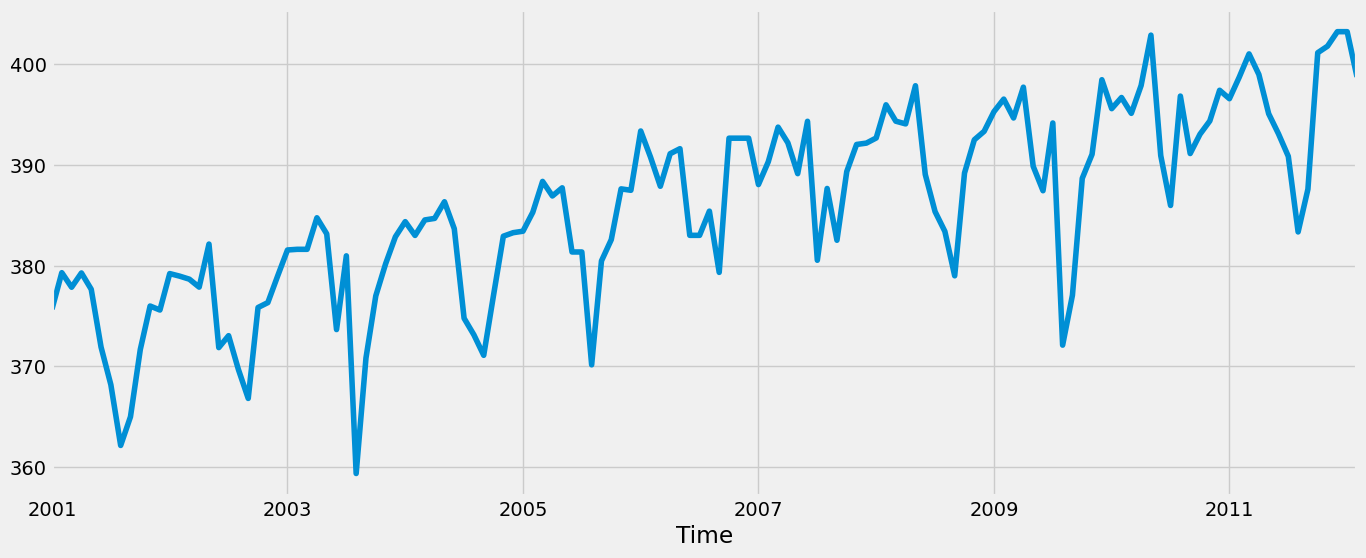

In [20]:
dt.plot(figsize=(15,6))
plt.show()

In [21]:
# 모델 파라미터 범위 정의
p = d = q =range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [22]:
# 라가비너 조합
print(pdq[1], seasonal_pdq[1])
print(pdq[1], seasonal_pdq[2])
print(pdq[2], seasonal_pdq[3])
print(pdq[2], seasonal_pdq[4])

(0, 0, 1) (0, 0, 1, 12)
(0, 0, 1) (0, 1, 0, 12)
(0, 1, 0) (0, 1, 1, 12)
(0, 1, 0) (1, 0, 0, 12)


In [23]:
warnings.filterwarnings("ignore")

min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

# AIC가 가장 낮은 파라미터 조합 찾기
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                dt,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

(0, 0, 0)x(0, 0, 0, 12): aic=1963.6753570712435
(0, 0, 0)x(0, 0, 1, 12): aic=1659.5109192511131
(0, 0, 0)x(0, 1, 0, 12): aic=768.2484648359497
(0, 0, 0)x(0, 1, 1, 12): aic=692.5159141769927
(0, 0, 0)x(1, 0, 0, 12): aic=755.6876506281936
(0, 0, 0)x(1, 0, 1, 12): aic=679.2407026180017
(0, 0, 0)x(1, 1, 0, 12): aic=693.9488318984639
(0, 0, 0)x(1, 1, 1, 12): aic=689.1121681151153
(0, 0, 1)x(0, 0, 0, 12): aic=1774.486896581206
(0, 0, 1)x(0, 0, 1, 12): aic=1487.7410207517562
(0, 0, 1)x(0, 1, 0, 12): aic=764.4305189063273
(0, 0, 1)x(0, 1, 1, 12): aic=683.4665679700412
(0, 0, 1)x(1, 0, 0, 12): aic=756.3736238583704
(0, 0, 1)x(1, 0, 1, 12): aic=676.3065789598622
(0, 0, 1)x(1, 1, 0, 12): aic=688.1372890434338
(0, 0, 1)x(1, 1, 1, 12): aic=679.0287296331776
(0, 1, 0)x(0, 0, 0, 12): aic=835.6303430265474
(0, 1, 0)x(0, 0, 1, 12): aic=768.0838701517271
(0, 1, 0)x(0, 1, 0, 12): aic=837.3427494462476
(0, 1, 0)x(0, 1, 1, 12): aic=677.9356641678518
(0, 1, 0)x(1, 0, 0, 12): aic=772.8556206214316
(0, 1, 0)x

In [24]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=599.2106187010583, min_params=(0, 1, 1), min_params_seasonal=(1, 1, 1, 12)


In [25]:
# 모델이 잘 fitting 되었는지 요약
results = min_model 
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.8596,0.050,-17.102,0.000,-0.958,-0.761
ar.S.L12,-0.3641,0.072,-5.050,0.000,-0.505,-0.223
ma.S.L12,-1.0000,524.108,-0.002,0.998,-1028.233,1026.233
sigma2,11.3995,5974.786,0.002,0.998,-1.17e+04,1.17e+04


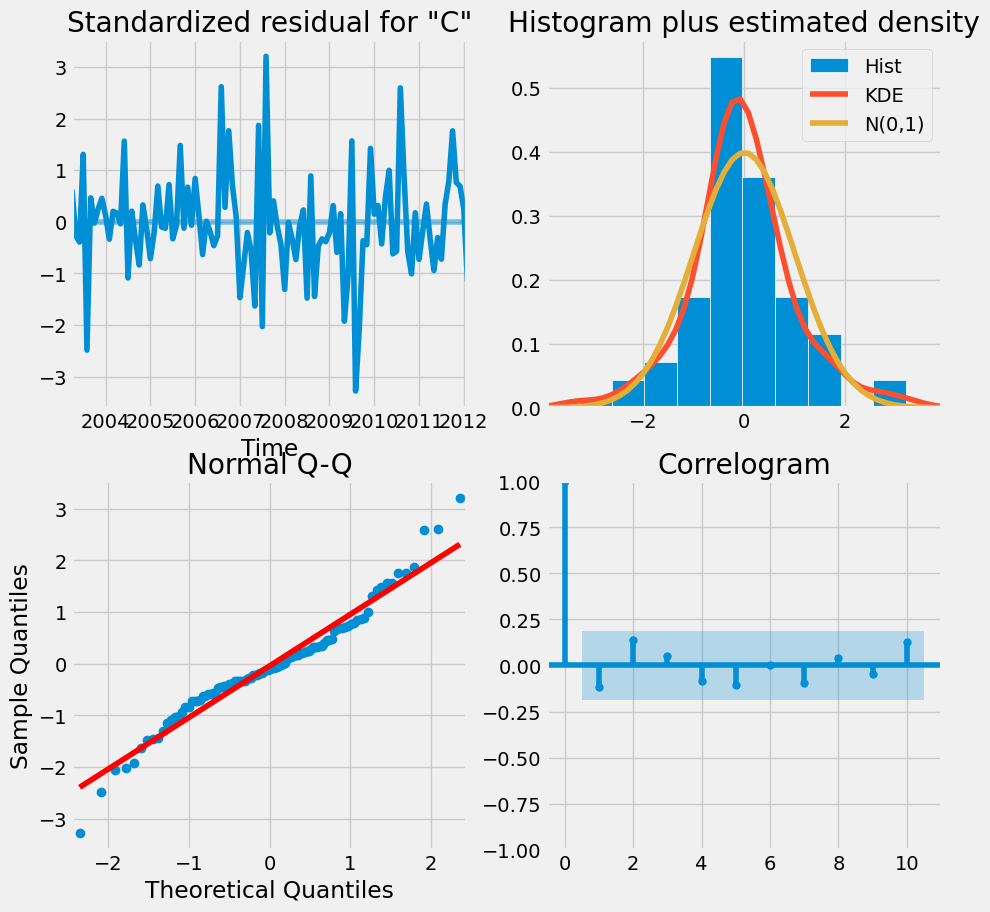

In [26]:
results.plot_diagnostics(figsize=(10, 10))
plt.show()

In [27]:
# 신뢰 구간 생성
pred = results.get_prediction(start=pd.to_datetime('2008-09-30'), dynamic=False)
pred_ci = pred.conf_int()


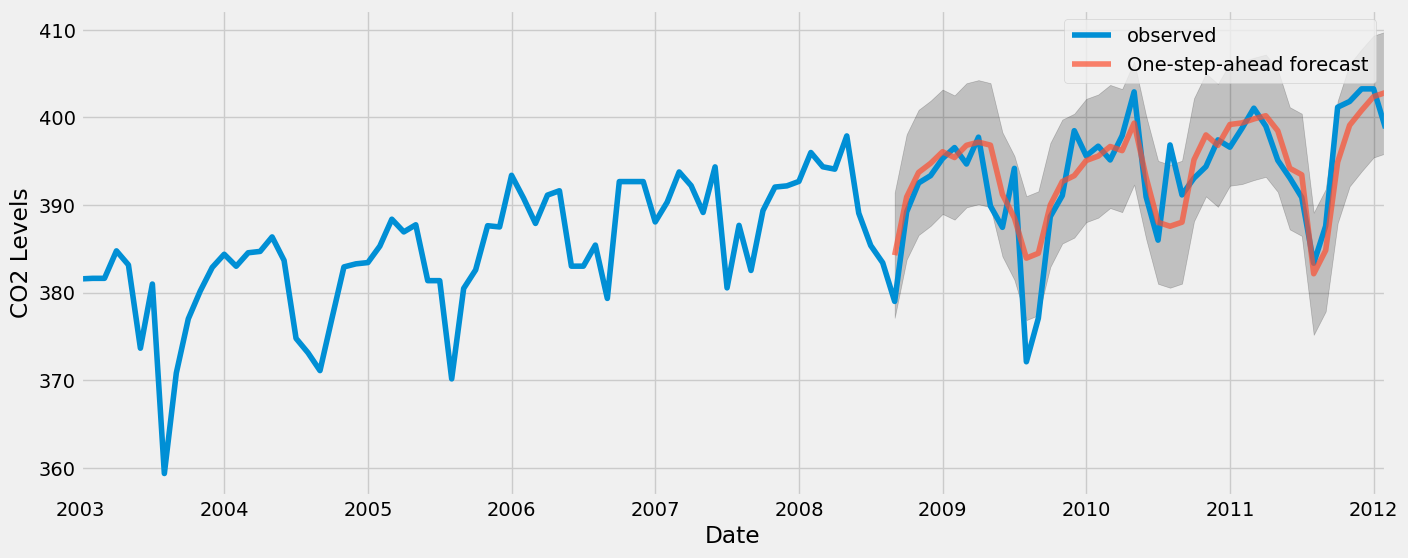

In [28]:
# 관측 데이터, 예측 및 신뢰 구간 그래프로 출력
ax = dt['2003':].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step-ahead forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [29]:
# MSE(평균 제곱 오차) 계산
y_forecasted = pred.predicted_mean
y_truth = dt['2008-09-30':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 14.58


In [30]:
# 신뢰 구간 생성
pred_dynamic = results.get_prediction(start=pd.to_datetime('2008-09-30'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

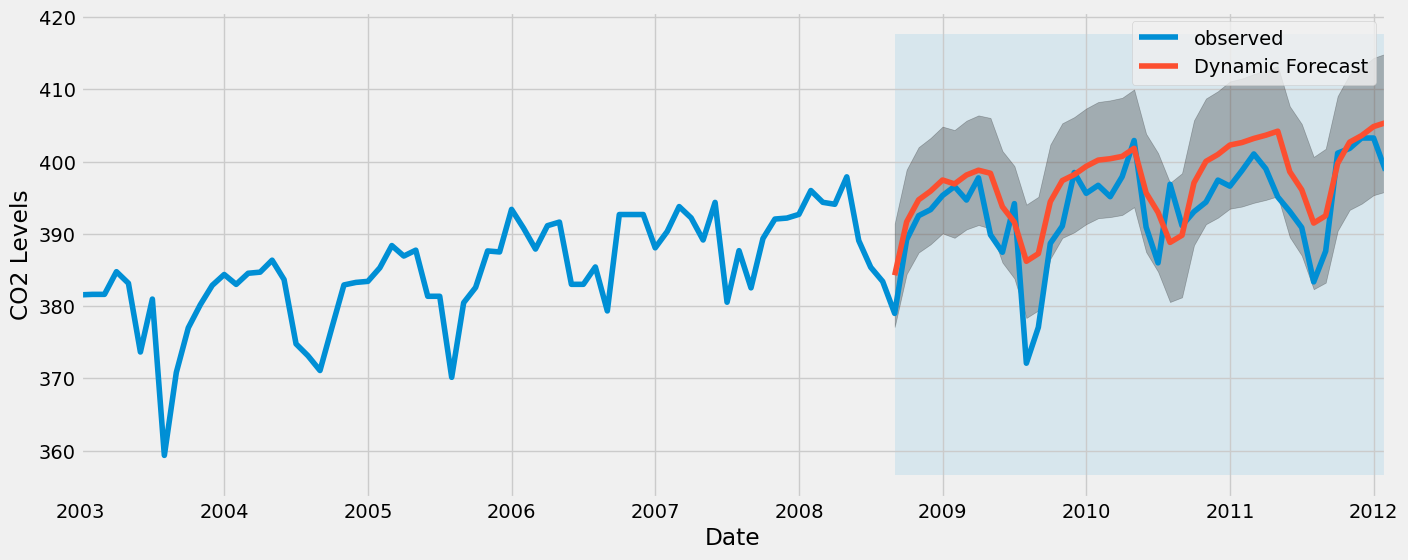

In [32]:
ax = dt['2003':].plot(label='observed', figsize=(15, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(
    pred_dynamic_ci.index,
    pred_dynamic_ci.iloc[:, 0],
    pred_dynamic_ci.iloc[:, 1],
    color='k',
    alpha=.25)

ax.fill_betweenx(
    ax.get_ylim(),
    pd.to_datetime('2008-09-30'),
    dt.index[-1],
    alpha=.1,
    zorder=-1)
# 레이블 추가
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [33]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = dt['2005-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 27.92


In [34]:
pred_uc = results.get_forecast(steps=300)
pred_ci = pred_uc.conf_int()

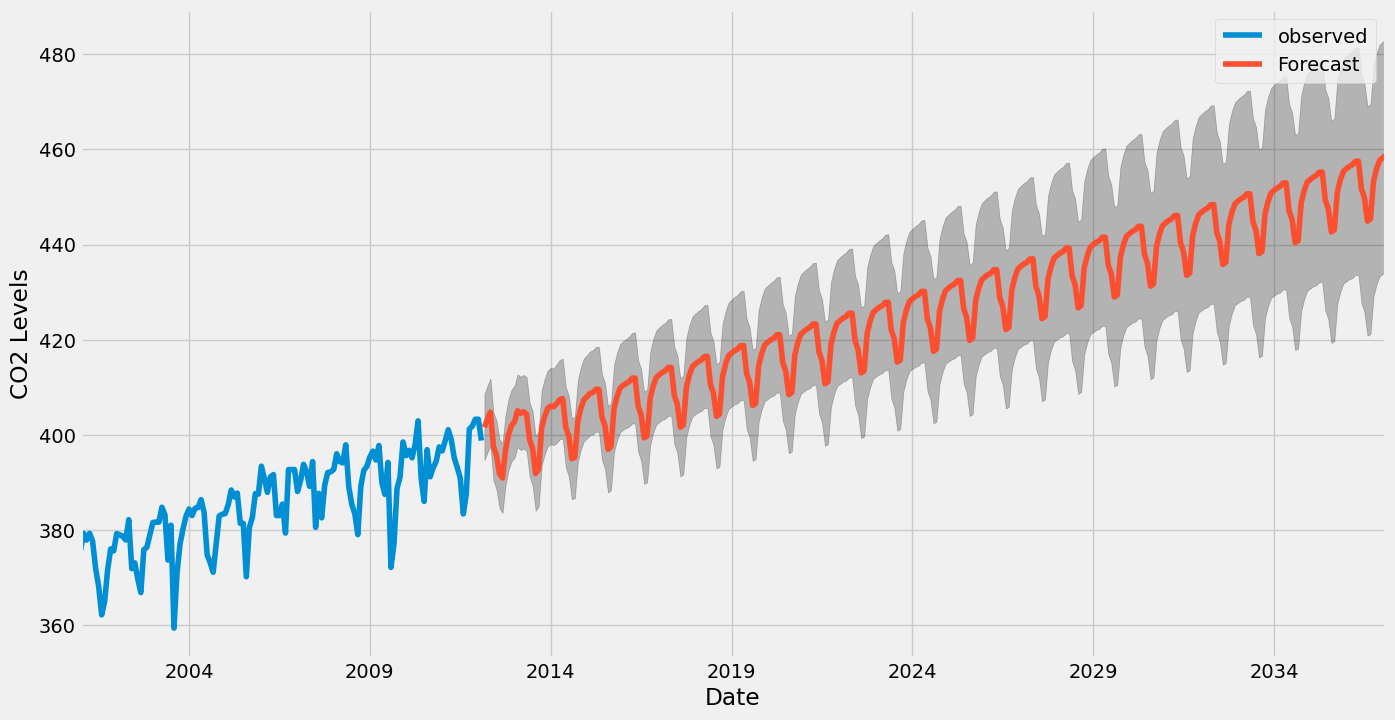

In [35]:
ax = dt.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()